<font size="6.2">Summary</font>  

LangGraph is an open-source framework by LangChain designed for constructing advanced multi-agent workflows powered by large language models (LLMs). This notebook begins by exploring Corrective Retrieval-Augmented Generation (RAG) and demonstrating use cases that highlight how self-grading or self-reflection can improve retrieval accuracy. It then covers techniques for enhancing questions to optimize document search. Finally, LangGraph is used to implement Corrective RAG, refine queries, and perform web searches to produce more reliable results.

Python functions and data files needed to run this notebook are available via this [link](https://github.com/MehdiRezvandehy/LangChain-in-Action-LLM-Applications-with-RAG-and-Agents.git).

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
from dotenv import load_dotenv
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_core.prompts import ChatPromptTemplate
# pydantic libabray for defining the expected input and output
from pydantic import BaseModel, Field
from langchain_openai import ChatOpenAI
load_dotenv(override=True)

# Load API keys
os.environ['OPENAI_API_KEY'] = os.environ.get("OPENAI_API_KEY")
os.environ["TAVILY_API_KEY"] = os.environ.get("TAVILY_API_KEY")
os.environ["EMAIL_API_KEY"] = os.environ.get("EMAIL_API_KEY")

USER_AGENT environment variable not set, consider setting it to identify your requests.


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Corrective-Retrieval-Augmented-Generation" data-toc-modified-id="Corrective-Retrieval-Augmented-Generation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Corrective Retrieval Augmented Generation</a></span><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Load-Documents" data-toc-modified-id="Load-Documents-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Load Documents</a></span></li><li><span><a href="#Corrected-Retrieval" data-toc-modified-id="Corrected-Retrieval-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Corrected Retrieval</a></span></li></ul></li><li><span><a href="#Prebuilt-RAG-Prompt-Template" data-toc-modified-id="Prebuilt-RAG-Prompt-Template-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Prebuilt RAG Prompt Template</a></span><ul class="toc-item"><li><span><a href="#Enhance-Questions-to-Optimize-Document-Search" data-toc-modified-id="Enhance-Questions-to-Optimize-Document-Search-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Enhance Questions to Optimize Document Search</a></span></li><li><span><a href="#Building-Rubric-to-Evaluate-Response" data-toc-modified-id="Building-Rubric-to-Evaluate-Response-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Building Rubric to Evaluate Response</a></span></li></ul></li><li><span><a href="#Using-LangGraph-to-Construct-the-Graph" data-toc-modified-id="Using-LangGraph-to-Construct-the-Graph-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Using <a href="https://www.langchain.com/" rel="nofollow" target="_blank">LangGraph</a> to Construct the Graph</a></span><ul class="toc-item"><li><span><a href="#Function-for-Graph's-Nodes" data-toc-modified-id="Function-for-Graph's-Nodes-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Function for Graph's Nodes</a></span></li><li><span><a href="#Functions-for-Graph's-Edges" data-toc-modified-id="Functions-for-Graph's-Edges-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Functions for Graph's Edges</a></span></li><li><span><a href="#Build-the-Graph" data-toc-modified-id="Build-the-Graph-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Build the Graph</a></span></li><li><span><a href="#Run-the-Graph" data-toc-modified-id="Run-the-Graph-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Run the Graph</a></span></li></ul></li><li><span><a href="#RAG-Driven-Auto-Explorer" data-toc-modified-id="RAG-Driven-Auto-Explorer-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>RAG-Driven Auto Explorer</a></span></li><li><span><a href="#Send-Email" data-toc-modified-id="Send-Email-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Send Email</a></span><ul class="toc-item"><li><span><a href="#Use-an-App-Password" data-toc-modified-id="Use-an-App-Password-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Use an App Password</a></span></li><li><span><a href="#Automatic-Email-Delivery-Tool" data-toc-modified-id="Automatic-Email-Delivery-Tool-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Automatic Email Delivery Tool</a></span><ul class="toc-item"><li><span><a href="#Put-Python-script-in-a-GitHub-repository" data-toc-modified-id="Put-Python-script-in-a-GitHub-repository-5.2.1"><span class="toc-item-num">5.2.1&nbsp;&nbsp;</span>Put Python script in a GitHub repository</a></span></li><li><span><a href="#Move-app-password-into-GitHub-Secrets" data-toc-modified-id="Move-app-password-into-GitHub-Secrets-5.2.2"><span class="toc-item-num">5.2.2&nbsp;&nbsp;</span>Move app password into GitHub Secrets</a></span></li><li><span><a href="#Create-the-GitHub-Action-(scheduler)" data-toc-modified-id="Create-the-GitHub-Action-(scheduler)-5.2.3"><span class="toc-item-num">5.2.3&nbsp;&nbsp;</span>Create the GitHub Action (scheduler)</a></span></li><li><span><a href="#Update-Python-script-to-read-secrets-from-env-vars" data-toc-modified-id="Update-Python-script-to-read-secrets-from-env-vars-5.2.4"><span class="toc-item-num">5.2.4&nbsp;&nbsp;</span>Update Python script to read secrets from env vars</a></span></li></ul></li></ul></li><li><span><a href="#Summary" data-toc-modified-id="Summary-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Summary</a></span></li><li><span><a href="#Appendix" data-toc-modified-id="Appendix-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Appendix</a></span></li></ul></div>

# Corrective Retrieval Augmented Generation
## Introduction

**Corrective RAG (CRAG)** is an enhanced version of the standard Retrieval-Augmented Generation (RAG) framework that introduces *self-reflection* and *corrective behavior* into the retrieval and generation process.


🔍 **What is RAG?**

Traditional **RAG** systems:
1. **Retrieve** documents relevant to a query from a knowledge base.
2. **Augment** the query with those documents.
3. **Generate** an answer using a language model.

But: RAG assumes the retriever always returns useful content—which isn’t always true.

---

✅ What is **Corrective RAG (CRAG)**?

**CRAG** introduces a feedback loop where the system evaluates the quality of the retrieved documents *before* generating an answer.

**Key Concepts in CRAG:**
1. **Self-grading or Self-reflection**  
   After retrieval, each document is graded for *relevance* using a language model.

2. **Corrective Behavior**
   - If **some documents are relevant**, proceed with generation (possibly filtering out irrelevant ones).
   - If **no documents are relevant** or the model is **uncertain**, the system:
     - Supplements or replaces retrieval by using a **secondary data source** (e.g., a web search like Tavily).
     - Optionally rewrites the query to improve results.

## Load Documents

In [2]:
# Define source URLs to load articles from
source_links = [
    "https://www.geeksforgeeks.org/region-proposal-network-rpn-in-object-detection/",
    "https://www.geeksforgeeks.org/machine-learning/faster-r-cnn-ml/",
    "https://www.geeksforgeeks.org/what-is-ordinal-data/",
    "https://www.geeksforgeeks.org/introduction-convolution-neural-network/",
    "https://d2l.ai/chapter_computer-vision/"
]

# Load documents from the URLs
raw_documents = [WebBaseLoader(link).load() for link in source_links]
flattened_docs = [doc for group in raw_documents for doc in group]

# Initialize a text splitter for chunking the documents
chunker = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=100
)

chunked_documents = chunker.split_documents(flattened_docs)

# Create a vector store with embeddings
doc_vectorstore = Chroma.from_documents(
    documents=chunked_documents,
    collection_name="cnn-rpn-knowledge-base",
    embedding=OpenAIEmbeddings(),
)

# Create a retriever from the vector store
doc_retriever = doc_vectorstore.as_retriever()

In [3]:
query = "What is Intersection-Over-Union?"
results = doc_retriever.get_relevant_documents(query)

for result in results:
    print(result.page_content[:100], '...', result.metadata['source'])

C:\Users\mrezv\AppData\Local\Temp\ipykernel_26540\1528654845.py:2: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  results = doc_retriever.get_relevant_documents(query)


Intersection-Over-Union (IoU)The foreground and background labels are assigned based on a metric cal ... https://www.geeksforgeeks.org/region-proposal-network-rpn-in-object-detection/
14.4. Anchor Boxes
14.4.1. Generating Multiple Anchor Boxes
14.4.2. Intersection over Union (IoU)
14 ... https://d2l.ai/chapter_computer-vision/
training allows RPN and the detection network to share features.3. Region of Interest(RoI) PoolingRe ... https://www.geeksforgeeks.org/machine-learning/faster-r-cnn-ml/
14.1. Image Augmentation
14.1.1. Common Image Augmentation Methods
14.1.2. Training with Image Augme ... https://d2l.ai/chapter_computer-vision/


## Corrected Retrieval
Assign a 'Relevant' or 'Not Relevant' label to each retrieved document depending on its relevance.

In [43]:
# Custom schema for grading document relevance
class RelevanceScore(BaseModel):
    """Binary relevance indicator for retrieved content."""

    relevance: str = Field(
        description="Return strictly 'Yes' if the document contains the information needed to answer the question directly. Otherwise return 'No'."
    )
    justification: str = Field(
        description="A short explanation (one sentence) why you said Yes or No."
    )

# LLM setup with structured output schema
grader_model = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Bind LLM with the output schema
structured_grader = grader_model.with_structured_output(RelevanceScore)

# Prompt definition
grading_instruction = """Return 'Yes' or 'No' to indicate if the document is relevant to the given question."""

grading_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", grading_instruction),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

# Composing the grader pipeline
document_grader = grading_prompt | structured_grader

# Iterate over retrieved documents and evaluate relevance
print(f'Question: {query}\n')
for result in results:
    content = result.page_content
    evaluation = document_grader.invoke({"document": content, "question": query})
    source = result.metadata['source']
    print(f'{evaluation}\ndocument: {content[:100]}\nsource: {source}')
    print('--------------------------------------------')

Question: What is Intersection-Over-Union?

relevance='Yes' justification='The document provides a clear definition of Intersection-Over-Union (IoU) and explains how it is calculated.'
document: Intersection-Over-Union (IoU)The foreground and background labels are assigned based on a metric cal
source: https://www.geeksforgeeks.org/region-proposal-network-rpn-in-object-detection/
--------------------------------------------
relevance='Yes' justification="The document includes a section titled 'Intersection over Union (IoU)', which directly addresses the user's question about what Intersection-Over-Union is."
document: 14.4. Anchor Boxes
14.4.1. Generating Multiple Anchor Boxes
14.4.2. Intersection over Union (IoU)
14
source: https://d2l.ai/chapter_computer-vision/
--------------------------------------------
relevance='No' justification='The document does not mention Intersection-Over-Union or provide any information related to it.'
document: training allows RPN and the detection netwo

# Prebuilt RAG Prompt Template

In [44]:
from langchain import hub

# Load a prebuilt RAG prompt template from the LangChain hub
rag_prompt_template = hub.pull("rlm/rag-prompt")

# Display the type and content of each message in the prompt template
for msg in rag_prompt_template.messages:
    print(type(msg))
    print(msg.prompt.template)
    print('--------------------------------------------')

<class 'langchain_core.prompts.chat.HumanMessagePromptTemplate'>
You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:
--------------------------------------------


In [45]:
from langchain_core.output_parsers import StrOutputParser

# Initialize the language model
chat_model = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

# Helper function to format retrieved documents
def join_documents(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Construct the RAG pipeline
# Note: StrOutputParser() ensures clean string output from the LLM
rag_pipeline = rag_prompt_template | chat_model | StrOutputParser()

# Execute the chain with context and question
response = rag_pipeline.invoke({
    "context": join_documents(results),
    "question": query
})

print(response)

Intersection-Over-Union (IoU) is a metric used to measure the overlap between an anchor box and the object of interest. It is calculated as the ratio of the area of intersection to the area of the union of the two boxes. An IoU greater than 0.7 typically indicates that the area is classified as foreground.


## Enhance Questions to Optimize Document Search

In [46]:
# Using a different LLM model to demonstrate flexibility in multi-model usage
search_optimizer_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Prompt template for rewriting questions to be more effective for web search
system_instruction = """You are a query rewriter that improves an input question for optimal web search results. 
Analyze the question and identify its underlying semantic intent or meaning."""

query_rewrite_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_instruction),
        (
            "human",
            "Here is the original query: \n\n {question} \n Please rewrite it to be more effective.",
        ),
    ]
)

# Construct the pipeline: prompt -> LLM -> output parser
query_optimizer = query_rewrite_prompt | search_optimizer_llm | StrOutputParser()

# Execute with a sample question
print(f"Original question: {query}")
optimized_query = query_optimizer.invoke({"question": query})
print(f"Optimized question: {optimized_query}")


Original question: What is Intersection-Over-Union?
Optimized question: What is the Intersection over Union (IoU) metric, and how is it used in image segmentation and object detection?


## Building Rubric to Evaluate Response

A Chain of Thought prompt encourages the model to explicitly explain its reasoning steps before giving a final answer. It's especially useful in evaluation or multi-step decision tasks.

This prompt is explicitly guided to produce a reasoning step before each rating. This aligns perfectly with Chain of Thought prompting.

In [47]:
import json

template_reason = '''
You are evaluating whether an assistant’s response fully and correctly answers all parts of a user’s question.

Your task:
- Provide a concise **reason** explaining whether the response answers all questions.
- Assign a **score** from 1 to 10 based on completeness.

### User Question
{query}

### Assistant's Response
{llm_output}

### Output Format (JSON)
{{"reason": "...", "score": ...}}

'''

template_prompt = ChatPromptTemplate.from_template(template_reason)
# message template
messages = template_prompt.format_messages(query=query, 
                                           llm_output=response)
respose = chat_model.invoke(messages).content
json.loads(respose)

{'reason': 'The response provides a clear definition of Intersection-Over-Union (IoU) and explains how it is calculated, but it lacks detail on its applications and significance in various contexts, such as in object detection or image segmentation.',
 'score': 7}

# Using [LangGraph](https://www.langchain.com/) to Construct the Graph

[LangGraph](https://www.langchain.com/) is an open-source framework developed by LangChain for building complex, multi-agent workflows using large language models (LLMs). Unlike traditional linear pipelines, LangGraph employs a graph-based architecture where agents—each handling specific tasks—are represented as nodes, and their interactions are defined by edges, allowing for dynamic, stateful, and iterative processes.

This design enables the creation of sophisticated AI systems where agents can collaborate, adapt based on feedback, and incorporate human-in-the-loop interactions, making it particularly effective for applications requiring modularity, scalability, and flexibility 

In [48]:
from typing import List
from typing_extensions import TypedDict
from typing import List, Any

# Define a structured dictionary to track the workflow state of the graph process
class PipelineState(TypedDict):
    """
    A dictionary-style representation of the current state in the graph-based pipeline.

    Attributes:
        user_query (str): The original or reformulated question.
        llm_output (str): The response generated by the language model.
        retrieved_docs (List[str]): A collection of documents retrieved based on the query.
        refine_query_count (int): Number of times the query has been rephrased.
        web_search_count (int): Number of web search.
        enable_web_search (str): Placeholder indicating if a web search should be triggered
                                 (functionality not implemented in this version).
    """

    query: str
    doc_retriever: Any
    llm_output: str
    retrieved_docs: List[str]
    refine_query_count: int
    web_search_count:int
    enable_web_search: str


## Function for Graph's Nodes

This section defines a set of modular functions that operate on a shared query state to build a retrieval-augmented generation (RAG) pipeline. Each function is responsible for a specific step in the process and modifies or extends the shared QueryState dictionary.

The overall flow is structured to be stateful and composable, making it suitable for integration with graph-based execution frameworks like LangGraph.

In [49]:
from langchain.schema import Document
import uuid
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter


def initialize_state(query_state):
    """
    Initializes values in the query state.

    Args:
        query_state (dict): The current state of the query workflow.

    Returns:
        dict: State dictionary with initialized refine_query_count and web_search_count.
    """
    print("---INITIALIZE QUERY STATE---")
    return {"refine_query_count": 0, 
            "web_search_count": 0,
            "doc_retriever": query_state["doc_retriever"],
           }

def fetch_documents(query_state):
    """
    Retrieves relevant documents for the given query.

    Args:
        query_state (dict): The current state of the query workflow.

    Returns:
        dict: An updated state dictionary with a new key 'retrieved_docs'.
    """
    print("---FETCH DOCUMENTS---")

    query = query_state["query"]

    # Perform document retrieval
    doc_retriever = query_state["doc_retriever"]  
    relevant_docs = doc_retriever.get_relevant_documents(query)
    return {"retrieved_docs": relevant_docs}

def get_retriever(source_links):
    """
    Args:
        source_links: list of websites to get documents

    Returns:
        doc_retriever: vectore score
    """
    # Load documents from the URLs
    raw_documents = [WebBaseLoader(link).load() for link in source_links]
    flattened_docs = [doc for group in raw_documents for doc in group]
    
    # Initialize a text splitter for chunking the documents
    chunker = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=250, chunk_overlap=100
    )
    
    chunked_documents = chunker.split_documents(flattened_docs)
    collection_id = f"collection-{uuid.uuid4()}"
    
    # Create a vector store with embeddings
    doc_vectorstore = Chroma.from_documents(
        documents=chunked_documents,
        collection_name=collection_id,
        embedding=OpenAIEmbeddings(),
        persist_directory=None, # <- in-memory, no history
    )
    
    # Create a retriever from the vector store
    doc_retriever = doc_vectorstore.as_retriever()
    return doc_retriever

def filter_relevant_documents(query_state):
    """
    Evaluates and filters retrieved documents for relevance to the query.

    Args:
        query_state (dict): The current state of the query workflow.

    Returns:
        dict: Updated state with only relevant documents and web search indicator.
    """
    print("---EVALUATE DOCUMENT RELEVANCE---")
    query = query_state["query"]
    documents = query_state["retrieved_docs"]

    filtered_results = []
    should_perform_web_search = "No"

    for doc in documents:
        score = document_grader.invoke({
            "question": query,
            "document": doc.page_content
        })
        is_relevant = score.relevance
        print(doc.metadata.get('source', 'Unknown'), f'Score: {is_relevant}')

        if is_relevant == "Yes":
            print("---DOCUMENT IS RELEVANT---")
            filtered_results.append(doc)

    if not filtered_results:
        print("---NO RELEVANT DOCUMENTS FOUND---")
        should_perform_web_search = "Yes"

    return {
        "retrieved_docs": filtered_results,
        "perform_web_search": should_perform_web_search
    }


def refine_query(query_state):
    """
    Rewrites the input query to improve clarity and search effectiveness.

    Args:
        query_state (dict): The current state of the query workflow.

    Returns:
        dict: Updated state with a refined query and incremented transformation count.
    """
    print("---REFINE QUERY---")

    query = query_state["query"]
    refine_query_count = query_state["refine_query_count"] + 1

    # Rewrite the query using a question rewriter
    improved_query = query_optimizer.invoke({"question": query})

    print("---IMPROVED QUERY---")
    print(improved_query)

    return {
        "query": improved_query,
        "refine_query_count": refine_query_count}


def generate_response(query_state):
    """
    Generates a response using RAG (Retrieval-Augmented Generation).

    Args:
        query_state (dict): The current state of the query workflow.

    Returns:
        dict: An updated state dictionary with a new key 'llm_output'.
    """
    print("---GENERATE RESPONSE---")

    query = query_state["query"]
    documents = query_state["retrieved_docs"]

    # Generate an answer using RAG
    response = rag_pipeline.invoke({
        "context": join_documents(documents),
        "question": query
    })

    return {"llm_output": response}


## Functions for Graph's Edges

You need to get your API key from https://app.tavily.com for web search.

In [50]:

from langchain.schema.document import Document
import json


def evaluate_response(query_state):
    """
    Args:
        query_state: The current query state containing the search question.

    Returns:
        int: score (from 1 to 10) for the agent response
    """
    #
    template_reason = '''
    You are evaluating whether an assistant’s response fully and correctly answers all parts of a user’s question.
    
    Your task:
    - Provide a concise **reason** explaining whether the response answers all questions.
    - Assign a **score** from 1 to 10 based on completeness.
    
    ### User Question
    {query}
    
    ### Assistant's Response
    {llm_output}
    
    ### Output Format (JSON)
    {{"reason": "...", "score": ...}}
    
    '''
    
    print(
        "---ASSESSING RESPONSE: PREDICT SCORE FOR LLM RESPONSE---"
    )  
    query = query_state["query"]
    generate_response = query_state["llm_output"]
    template_prompt = ChatPromptTemplate.from_template(template_reason)
    # message template
    messages = template_prompt.format_messages(query=query, 
                                               llm_output=generate_response)
    respose = chat_model.invoke(messages).content
    

    return {
        "response_score": json.loads(respose)['score'],
        "llm_output": generate_response
    }


def web_search(query_state):
    """
    Executes a web search using the given query and returns a list of document objects.

    Args:
        query_state: The current query state containing the search question.

    Returns:
        Dict[str, Any]: Updated state including the original question and retrieved documents.
    """
    query = query_state["query"]
    web_search_count = query_state["web_search_count"] + 1
    #
    search_client = TavilySearchAPIWrapper()
    search_results = search_client.results(query=query, max_results=3)

    retrieved_docs = [
        Document(page_content=item["content"], metadata={"source": item["url"]})
        for item in search_results
    ]
    print(
        "---WEB SEARCH: RETRIEVED DOCS FROM WEB SEARCH---"
    ) 
    
    return {
        "query": query,
        "retrieved_docs": retrieved_docs,
        "web_search_count": web_search_count
    }


def decide_next_action(query_state):
    """
    Determines the next step in the workflow: whether to generate an answer
    or rephrase the query again for better document retrieval.

    Args:
        query_state (dict): The current state of the query process.

    Returns:
        str: The next action to take - either 'if_generate' or 'if_transform_query'.
    """

    print("---ASSESSING DOCUMENT RELEVANCE---")
    requires_web_search = query_state["perform_web_search"]

    if requires_web_search == "Yes":
        # If the query has already been transformed multiple times with no success,
        # proceed to generate an answer anyway.
        if query_state["refine_query_count"] >= 3:
            print(
                "---DECISION: MAX REWRITES REACHED AND NO RELEVANT DOCUMENTS FOUND → LETS APPLY WEB SEARCH---"
            )        

            return "apply_web_search"

        # Still below the rewrite threshold; attempt another reformulation.
        print(
            "---DECISION: NO RELEVANT DOCUMENTS FOUND YET → TRANSFORM QUERY AGAIN---"
        )
        return "apply_transform_query"

    else:
        # Relevant documents are present; move on to answer generation.
        print("---DECISION: RELEVANT DOCUMENTS FOUND → GENERATE---")
        return "apply_generate"

    
    
def decide_to_end(query_state):
    """
    Determines to end the workflow: 
    Args:
        query_state (dict): The current state of the query process.

    Returns:

    """

    print("---ASSESSING to END the WORKFLOW OR NOT ---")
    response_score_value = query_state["response_score"]

    if response_score_value >= 6:
        # If the score is bigger than 6, we can end the work. As we do not have
        # ground truth, score above 6 is high enough

        print(
            "---DECISION: THE SCORE IS REASONABLE → END---"
        )

        return "apply_end"

    elif query_state["web_search_count"]<=2:
        # Relevant documents are present; move on to answer generation.
        print("---DECISION: THE SCORE IS LOW → LETS APPLY WEB SEARCH (again)---")
        return "apply_web_search" 
    
    else :
        # Relevant documents are present; move on to answer generation.
        print("---DECISION: THE SCORE IS LOW APPLY MULTIPPLE WEB SEARCH CANNOT FIND AN ANSWER → END---")
        return "apply_end"    

## Build the Graph

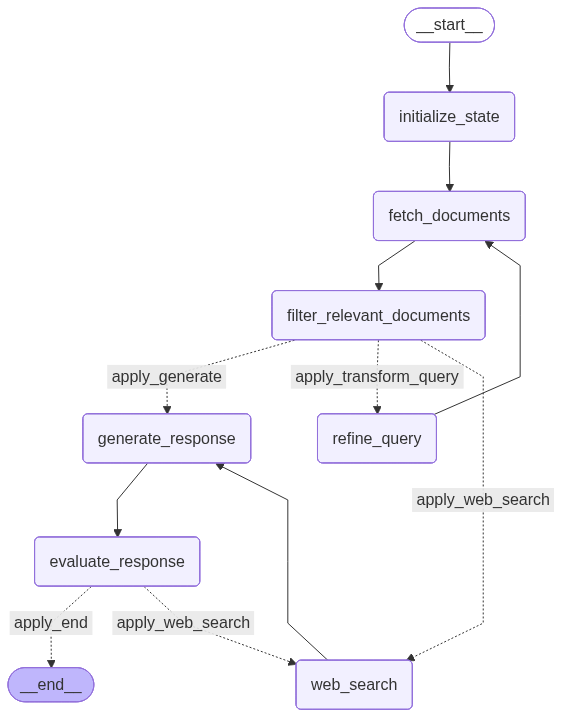

In [51]:
from langgraph.graph import START, END, StateGraph

# Create a new stateful graph using the defined PipelineState structure
pipeline_graph = StateGraph(PipelineState)

# Register nodes
pipeline_graph.add_node("initialize_state", initialize_state)
pipeline_graph.add_node("fetch_documents", fetch_documents)
pipeline_graph.add_node("filter_relevant_documents", filter_relevant_documents)
pipeline_graph.add_node("generate_response", generate_response)
pipeline_graph.add_node("evaluate_response", evaluate_response)
pipeline_graph.add_node("refine_query", refine_query)
pipeline_graph.add_node("web_search", web_search)

# --- GRAPH LOGIC ---

# Start → Initialize
pipeline_graph.add_edge(START, "initialize_state")

# Initialize → Fetch Documents
pipeline_graph.add_edge("initialize_state", "fetch_documents")

# Fetch → Filter Relevant
pipeline_graph.add_edge("fetch_documents", "filter_relevant_documents")

# Filter → Branch
pipeline_graph.add_conditional_edges(
    "filter_relevant_documents",
    decide_next_action,
    {
        "apply_transform_query": "refine_query",
        "apply_web_search": "web_search",
        "apply_generate": "generate_response",
    }
)

# If refine_query → go back to fetch
pipeline_graph.add_edge("refine_query", "fetch_documents")

# If web_search → ALWAYS → generate_response
pipeline_graph.add_edge("web_search", "generate_response")

# Normal generation → evaluation
pipeline_graph.add_edge("generate_response", "evaluate_response")

# Evaluate → choose end or web_search retry
pipeline_graph.add_conditional_edges(
    "evaluate_response",
    decide_to_end,
    {
        "apply_end": END,
        "apply_web_search": "web_search",
    }
)

# Compile graph
retrieval_qa_pipeline = pipeline_graph.compile()
retrieval_qa_pipeline

## Run the Graph

* **Query 1**

In [52]:
source_links = [
    "https://www.geeksforgeeks.org/region-proposal-network-rpn-in-object-detection/",
    "https://www.geeksforgeeks.org/machine-learning/faster-r-cnn-ml/",
    "https://www.geeksforgeeks.org/what-is-ordinal-data/",
    "https://www.geeksforgeeks.org/introduction-convolution-neural-network/",
    "https://d2l.ai/chapter_computer-vision/"
]

doc_retriever = get_retriever(source_links)

inputs = {
    "query": "What is feature map?",
    "doc_retriever": doc_retriever
} 
    
for output in retrieval_qa_pipeline.stream(inputs):
    for key, value in output.items():
        # Node
        print(f'----------Node "{key}" Completed-------------')
        print("\n")
# Final generation
print(value["llm_output"])

---INITIALIZE QUERY STATE---
----------Node "initialize_state" Completed-------------


---FETCH DOCUMENTS---
----------Node "fetch_documents" Completed-------------


---EVALUATE DOCUMENT RELEVANCE---
https://www.geeksforgeeks.org/region-proposal-network-rpn-in-object-detection/ Score: No
https://www.geeksforgeeks.org/introduction-convolution-neural-network/ Score: Yes
---DOCUMENT IS RELEVANT---
https://www.geeksforgeeks.org/introduction-convolution-neural-network/ Score: No
https://www.geeksforgeeks.org/machine-learning/faster-r-cnn-ml/ Score: No
---ASSESSING DOCUMENT RELEVANCE---
---DECISION: RELEVANT DOCUMENTS FOUND → GENERATE---
----------Node "filter_relevant_documents" Completed-------------


---GENERATE RESPONSE---
----------Node "generate_response" Completed-------------


---ASSESSING RESPONSE: PREDICT SCORE FOR LLM RESPONSE---
---ASSESSING to END the WORKFLOW OR NOT ---
---DECISION: THE SCORE IS REASONABLE → END---
----------Node "evaluate_response" Completed-------------



* **Query 2**

In [53]:
source_links = [
    "https://www.ratehub.ca/"
]

doc_retriever = get_retriever(source_links)

inputs = {
    "query": "What is the best mortgage rate for 5‑year fixed in Calgary, also give name of the bank",
    "doc_retriever": doc_retriever
} 
for output in retrieval_qa_pipeline.stream(inputs):
    for key, value in output.items():
        # Node
        print(f'----------Node "{key}" Completed-------------')
        print("\n")
# Final generation
print(value["llm_output"])

---INITIALIZE QUERY STATE---
----------Node "initialize_state" Completed-------------


---FETCH DOCUMENTS---
----------Node "fetch_documents" Completed-------------


---EVALUATE DOCUMENT RELEVANCE---
https://www.ratehub.ca/ Score: No
https://www.ratehub.ca/ Score: No
https://www.ratehub.ca/ Score: No
https://www.ratehub.ca/ Score: No
---NO RELEVANT DOCUMENTS FOUND---
---ASSESSING DOCUMENT RELEVANCE---
---DECISION: NO RELEVANT DOCUMENTS FOUND YET → TRANSFORM QUERY AGAIN---
----------Node "filter_relevant_documents" Completed-------------


---REFINE QUERY---
---IMPROVED QUERY---
What are the current best mortgage rates for a 5-year fixed term in Calgary, and which banks offer them?
----------Node "refine_query" Completed-------------


---FETCH DOCUMENTS---
----------Node "fetch_documents" Completed-------------


---EVALUATE DOCUMENT RELEVANCE---
https://www.ratehub.ca/ Score: No
https://www.ratehub.ca/ Score: No
https://www.ratehub.ca/ Score: No
https://www.ratehub.ca/ Score: No
---

* **Query 3**

In [54]:
source_links = [
    "https://www.ratehub.ca/"
]

doc_retriever = get_retriever(source_links)

inputs = {
    "query": "What is Ordinal Chi-Square Test?",
    "doc_retriever": doc_retriever
}

for output in retrieval_qa_pipeline.stream(inputs):
    for key, value in output.items():
        # Node
        print(f'----------Node "{key}" Completed-------------')
        print("\n")
# Final generation
print(value["llm_output"])

---INITIALIZE QUERY STATE---
----------Node "initialize_state" Completed-------------


---FETCH DOCUMENTS---
----------Node "fetch_documents" Completed-------------


---EVALUATE DOCUMENT RELEVANCE---
https://www.ratehub.ca/ Score: No
https://www.ratehub.ca/ Score: No
https://www.ratehub.ca/ Score: No
https://www.ratehub.ca/ Score: No
---NO RELEVANT DOCUMENTS FOUND---
---ASSESSING DOCUMENT RELEVANCE---
---DECISION: NO RELEVANT DOCUMENTS FOUND YET → TRANSFORM QUERY AGAIN---
----------Node "filter_relevant_documents" Completed-------------


---REFINE QUERY---
---IMPROVED QUERY---
What is the Ordinal Chi-Square Test and how is it used in statistical analysis?
----------Node "refine_query" Completed-------------


---FETCH DOCUMENTS---
----------Node "fetch_documents" Completed-------------


---EVALUATE DOCUMENT RELEVANCE---
https://www.ratehub.ca/ Score: No
https://www.ratehub.ca/ Score: No
https://www.ratehub.ca/ Score: No
https://www.ratehub.ca/ Score: No
---NO RELEVANT DOCUMENTS FOU

**Visualize the Graph**

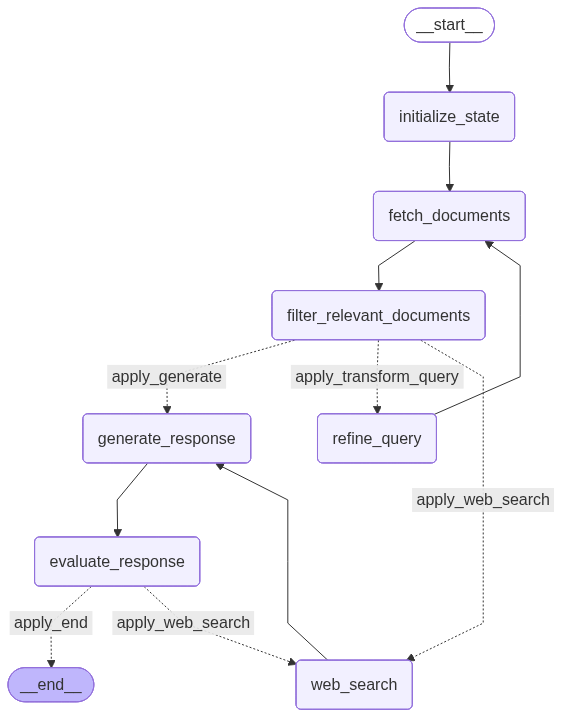

In [55]:
# Visualize our graph
from IPython.display import Image, display
try:
    display(Image(retrieval_qa_pipeline.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [56]:
# if the above fails try this (requires grandalf)
print(retrieval_qa_pipeline.get_graph().draw_ascii())

                                                    +-----------+                                                
                                                    | __start__ |                                                
                                                    +-----------+                                                
                                                           *                                                     
                                                           *                                                     
                                                           *                                                     
                                                 +------------------+                                            
                                                 | initialize_state |                                            
                                                 +------------------+                   

# RAG-Driven Auto Explorer 

This project builds a multi-source Retrieval-Augmented Generation (RAG) system that gathers SUV finance information from multiple car brands. The system retrieves data such as vehicle prices, finance offers, interest rates, promotions, lease options, and incentives from various online sources. It then normalizes and summarizes the details so users can compare SUV financing across brands in one place. The pipeline includes web retrieval, structured extraction, ranking, and final LLM reasoning to generate accurate, up-to-date results.

In [72]:
from datetime import date

today = date.today()
formatted_date = today.strftime("%B %Y") 

rag_inputs = [
    {
        "question": f"What current Nissan promotions are available in Alberta as of {formatted_date}?",
        "links": ["https://www.stadiumnissan.com/our-promotions.html"]
    },
    {
        "question": f"What Honda vehicle offers are available in Alberta as of {formatted_date}?",
        "links": ["https://www.honda.ca/special-offers/alberta"]
    },
    {
        "question": f"What are Toyota’s latest financing deals in Alberta as of {formatted_date}?",
        "links": ["https://www.shoptoyota.ca/alberta/en"]
    },
    {
        "question": f"What Mazda offers are available in Alberta as of {formatted_date}?",
        "links": ["https://albertamazdaoffers.ca/"]
    },
    {
        "question": f"What are Mercedes-Benz’s current special offers in Alberta as of {formatted_date}?",
        "links": ["https://www.mercedes-benz-countryhills.ca/en/special-offers"]
    }
]


In [60]:
rag_outputs = []
for inp in rag_inputs:
    doc_retriever = get_retriever(inp["links"])
    inputs = {
        "query": inp["question"],
        "doc_retriever": doc_retriever
    }
    for output in retrieval_qa_pipeline.stream(inputs):
        for key, value in output.items():
            # Node
            print(f'----------Node "{key}" Completed-------------')
            print("\n")
    # Final generation
    rag_outputs.append(value["llm_output"])

---INITIALIZE QUERY STATE---
----------Node "initialize_state" Completed-------------


---FETCH DOCUMENTS---
----------Node "fetch_documents" Completed-------------


---EVALUATE DOCUMENT RELEVANCE---
https://www.nissan.ca/alberta.html Score: No
https://www.nissan.ca/alberta.html Score: No
https://www.nissan.ca/alberta.html Score: No
https://www.nissan.ca/alberta.html Score: No
---NO RELEVANT DOCUMENTS FOUND---
---ASSESSING DOCUMENT RELEVANCE---
---DECISION: NO RELEVANT DOCUMENTS FOUND YET → TRANSFORM QUERY AGAIN---
----------Node "filter_relevant_documents" Completed-------------


---REFINE QUERY---
---IMPROVED QUERY---
What are the latest Nissan car promotions and special offers available in Alberta for December 2025?
----------Node "refine_query" Completed-------------


---FETCH DOCUMENTS---
----------Node "fetch_documents" Completed-------------


---EVALUATE DOCUMENT RELEVANCE---
https://www.nissan.ca/alberta.html Score: No
https://www.nissan.ca/alberta.html Score: No
https://w

---IMPROVED QUERY---
What are the latest Toyota car financing deals available in Alberta for December 2025?
----------Node "refine_query" Completed-------------


---FETCH DOCUMENTS---
----------Node "fetch_documents" Completed-------------


---EVALUATE DOCUMENT RELEVANCE---
https://www.shoptoyota.ca/alberta/en Score: No
https://www.shoptoyota.ca/alberta/en Score: No
https://www.shoptoyota.ca/alberta/en Score: No
https://www.shoptoyota.ca/alberta/en Score: No
---NO RELEVANT DOCUMENTS FOUND---
---ASSESSING DOCUMENT RELEVANCE---
---DECISION: NO RELEVANT DOCUMENTS FOUND YET → TRANSFORM QUERY AGAIN---
----------Node "filter_relevant_documents" Completed-------------


---REFINE QUERY---
---IMPROVED QUERY---
What are the current Toyota car financing offers in Alberta for December 2025?
----------Node "refine_query" Completed-------------


---FETCH DOCUMENTS---
----------Node "fetch_documents" Completed-------------


---EVALUATE DOCUMENT RELEVANCE---
https://www.shoptoyota.ca/alberta/en S

In [ ]:
value["llm_output"]

In [ ]:
from datetime import date

today = date.today()

def aggregate_answers(llm, rag_outputs):
    aggregation_prompt = f"""
    You are an expert synthesizer.
    
    Combine the following question results achieved from RAG into a clear and cohesive final summary separate them. Start
    with date of today {today}
    
    RAG Results:
    {"\n\n".join(
        f"RAG #{i+1}\nQuestion: {item_1['question']}\nAnswer:\n{item_2}"
        for i, (item_1, item_2) in enumerate(zip(rag_inputs, rag_outputs))
    )}
    """

    final = llm.invoke(aggregation_prompt)
    return final


In [ ]:
final_answer = aggregate_answers(chat_model, rag_outputs)

In [ ]:
from rich.console import Console
from rich.markdown import Markdown

console = Console()
console.print(Markdown(final_answer.content))

# Send Email

https://medium.com/nerd-for-tech/lets-run-cron-jobs-using-github-actions-df64496ffc4a

The output of the LangGraph can be email to your self or many other people

You **can** send emails programmatically *without directly putting your real email password in your code*, but **only using secure, official methods** provided by email services.

Here are the **safe and correct options**:

## Use an App Password

Email providers allow you to generate a **special app-specific password**.
This is *not* your real password and can be revoked anytime.

**Example (Gmail)**

1. Go to https://myaccount.google.com/security
2. Turn on **2-Step Verification** in your Google Account.
3. Go to **Security → App Passwords**
4. Generate one for “Mail”.
5. Use that password in your script instead of your real password.

🔒 This keeps your real password completely safe.



In [ ]:
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
import markdown

def send_email_report(subject, markdown_text, to_emails):
    msg = MIMEMultipart("alternative")
    msg["From"] = EMAIL_ADDRESS
    msg["To"] = ", ".join(to_emails)
    msg["Subject"] = subject

    # Convert markdown → HTML
    html_text = markdown.markdown(markdown_text)

    # Attach both plain and HTML versions
    msg.attach(MIMEText(markdown_text, "plain"))   # fallback
    msg.attach(MIMEText(html_text, "html"))        # formatted version

    # Send via Gmail
    with smtplib.SMTP_SSL("smtp.gmail.com", 465) as server:
        server.login(EMAIL_ADDRESS, APP_PASSWORD)
        server.send_message(msg)

    print(f"✅ Email sent to: {', '.join(to_emails)}")

    
markdown_report = final_answer.content

send_email_report(
    subject="🚗 Alberta Car Financing Update",
    markdown_text=markdown_report,
    to_emails=["mrezvandehy@gmail.com"]
)    

## Automatic Email Delivery Tool

### Put Python script in a GitHub repository

To run your Python script **automatically on a schedule** (daily/weekly/hourly) and send emails — you can use **GitHub Actions**.
This is the easiest way to run a script regularly **without keeping your computer on**.

Here’s the full, **simple** setup.

---



Your repo structure should look like:

```
your-repo/
  ├── send_report.py
  ├── requirements.txt
  └── .github/
        └── workflows/
              └── email.yml
```



### Move app password into GitHub Secrets

Never hard-code the Gmail app password in GitHub.

1. Open your repo on GitHub
2. Go to **Settings → Secrets and variables → Actions**
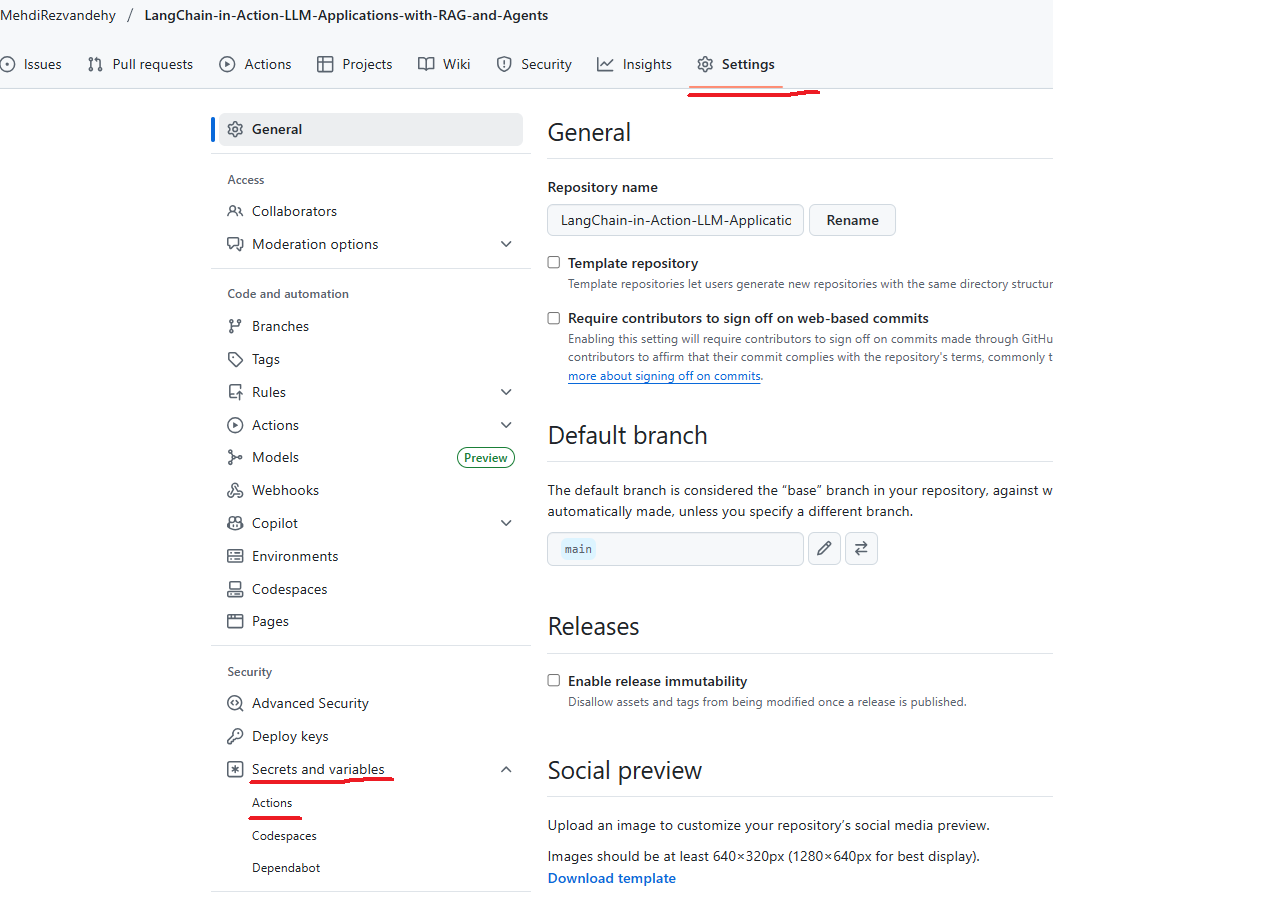
---
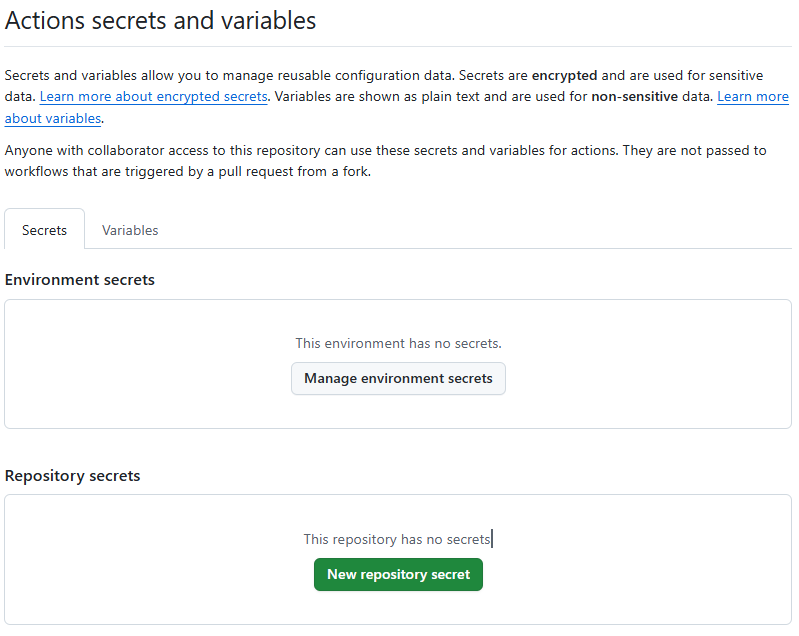


3. Click **New repository secret**
4. Add these secrets:



| Secret Name       | Value                        |
| ----------------- | ---------------------------- |
| **EMAIL_ADDRESS** | your email (`you@gmail.com`) |
| **APP_PASSWORD**  | your Gmail App Password      |
| **RECIPIENTS**    | comma separated emails       |


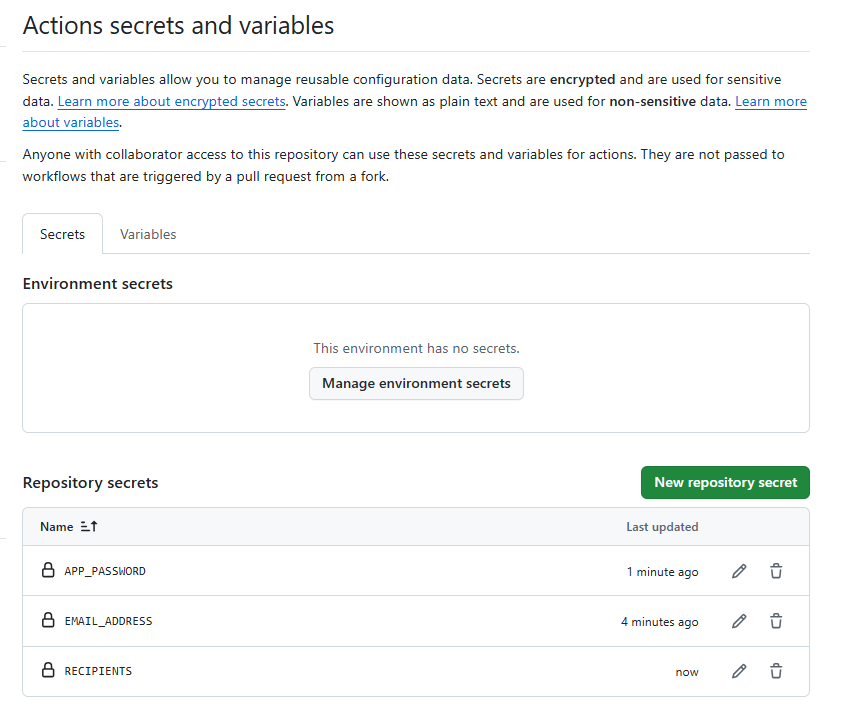

### Create the GitHub Action (scheduler)

In your repo, create:

```
.github/workflows/email.yml
```

Add this content:

```yaml
name: Send Email Report

on:
  schedule:
    - cron: "0 14 * * *"   # Runs every day at 14:00 UTC
  workflow_dispatch:        # allows manual runs

jobs:
  send-email:
    runs-on: ubuntu-latest

    steps:
    - name: Checkout repository
      uses: actions/checkout@v3

    - name: Set up Python
      uses: actions/setup-python@v4
      with:
        python-version: "3.10"

    - name: Install dependencies
      run: pip install -r requirements.txt

    - name: Run email script
      env:
        EMAIL_ADDRESS: ${{ secrets.EMAIL_ADDRESS }}
        APP_PASSWORD: ${{ secrets.APP_PASSWORD }}
        RECIPIENTS: ${{ secrets.RECIPIENTS }}
      run: automated_rag_email.py
```
---

### Update Python script to read secrets from env vars

Use the script below to send email report using Gmail's SMTP server.
It securely loads all sensitive information (email address, app password,
and recipient list) from environment variables, making it safe to use with
GitHub Actions or other automated workflows.

Environment variables required:
- EMAIL_ADDRESS : The Gmail address used to send emails
- APP_PASSWORD  : Gmail App Password (not your real password)
- RECIPIENTS    : Comma-separated list of recipient emails

The script builds a simple email message and sends it over an SSL-secured
connection to Gmail's SMTP server.

```python
import os
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart

EMAIL_ADDRESS = os.getenv("EMAIL_ADDRESS")
APP_PASSWORD = os.getenv("APP_PASSWORD")
RECIPIENTS = os.getenv("RECIPIENTS").split(",")

def send_email_report():
    msg = MIMEMultipart()
    msg["From"] = EMAIL_ADDRESS
    msg["To"] = ", ".join(RECIPIENTS)
    msg["Subject"] = "📊 Automated Report"

    msg.attach(MIMEText("Your automated report goes here!", "plain"))

    with smtplib.SMTP_SSL("smtp.gmail.com", 465) as server:
        server.login(EMAIL_ADDRESS, APP_PASSWORD)
        server.send_message(msg)

    print("Email sent!")

if __name__ == "__main__":
    send_email_report()
```

---

After pushing the code to GitHub, it will run automatically.

* GitHub Actions will execute the script **every day at 14:00 UTC**.
* You can adjust the schedule using cron syntax, for example:

  * Hourly: `0 * * * *`
  * Daily: `0 0 * * *`
  * Every Monday: `0 0 * * MON`

---

Your script now runs on GitHub automatically—no need to keep your computer on.



# Summary

From the code above, we can see that unlike Crew.ai, LangGraph allows us to explicitly define the behavior of our agent graph. However, this comes at the cost of ease of use—there's a significant amount of boilerplate just to create a single agent, and that's not even for a multi-agent setup. Much of the code involves manually specifying each step the agent should take. On the other hand, many people expect agents to figure things out on their own without needing such detailed instructions. So, between Crew and LangGraph, we’re already seeing a split in the agent ecosystem: LangGraph takes a more hardcoded, deterministic approach where the developer dictates the entire flow, while Crew leans into the idea of smart LLMs—just give them a task and the tools, and let them decide how to proceed.

# Appendix

In [63]:
class LangGraphRAG:
    """
    End-to-end Retrieval-Augmented Generation pipeline using LangGraph.
    Entire pipeline is constructed in __init__ and exposed through .pipeline
    """

    def __init__(self, source_links, llm_model="gpt-4o-mini"):
        import warnings
        warnings.filterwarnings("ignore")

        from dotenv import load_dotenv
        import uuid
        from langchain_openai import ChatOpenAI, OpenAIEmbeddings
        from langchain_community.document_loaders import WebBaseLoader
        from langchain_community.vectorstores import Chroma
        from langchain.text_splitter import RecursiveCharacterTextSplitter
        from langchain_core.prompts import ChatPromptTemplate
        from langchain_core.output_parsers import StrOutputParser
        from langchain import hub
        from pydantic import BaseModel, Field
        from typing import List, Any
        from typing_extensions import TypedDict

        load_dotenv(override=True)

        # --------------------------------------------
        # Store config
        # --------------------------------------------
        self.source_links = source_links
        self.llm_model = llm_model

        # --------------------------------------------
        # LLM
        # --------------------------------------------
        self.llm = ChatOpenAI(model=self.llm_model, temperature=0)

        # --------------------------------------------
        # Schema for relevance grading
        # --------------------------------------------
        class RelevanceScore(BaseModel):
            relevance: str = Field(description="'Yes' or 'No'")
            justification: str = Field(description="Short justification")

        self.RelevanceScore = RelevanceScore

        # bind structured output
        self.structured_grader = self.llm.with_structured_output(RelevanceScore)

        grading_instruction = """
        You are a document relevance evaluator.
        Return 'Yes' or 'No' to indicate if the document is relevant to the given question.
        """

        self.grading_prompt = ChatPromptTemplate.from_messages(
            [
                ("system", grading_instruction),
                ("human", "Retrieved document:\n{document}\n\nUser question:\n{question}")
            ]
        )

        self.document_grader = self.grading_prompt | self.structured_grader

        # ------------------------------------------------------------
        # Join documents helper
        # ------------------------------------------------------------
        def join_documents(docs):
            return "\n\n".join(d.page_content for d in docs)

        self.join_documents = join_documents

        # ------------------------------------------------------------
        # RAG Pipeline
        # ------------------------------------------------------------
        rag_prompt_template = hub.pull("rlm/rag-prompt")
        self.rag_pipeline = rag_prompt_template | self.llm | StrOutputParser()

        # --------------------------------------------
        # Query Rewriter
        # --------------------------------------------
        system_instruction = "Rewrite the query to be more effective for search."

        self.query_rewrite_prompt = ChatPromptTemplate.from_messages(
            [
                ("system", system_instruction),
                ("human", "Original query:\n{question}\nRewrite it.")
            ]
        )
        self.query_optimizer = self.query_rewrite_prompt | self.llm | StrOutputParser()

        # --------------------------------------------
        # Build retriever
        # --------------------------------------------
        self.doc_retriever = self._build_retriever(source_links)

        # --------------------------------------------
        # Graph State structure
        # --------------------------------------------
        class PipelineState(TypedDict):
            query: str
            doc_retriever: Any
            llm_output: str
            retrieved_docs: List[str]
            refine_query_count: int
            rewrite_count: int
            web_search_count:int
            perform_web_search: str

        self.PipelineState = PipelineState

        
        # --------------------------------------------
        # Build the LangGraph pipeline
        # --------------------------------------------
        from langgraph.graph import StateGraph, START, END
    
        # Create a new stateful graph using the defined PipelineState structure
        pipeline_graph = StateGraph(PipelineState)
        
        # Register nodes
        pipeline_graph.add_node("initialize_state", self.initialize_state)
        pipeline_graph.add_node("fetch_documents", self.fetch_documents)
        pipeline_graph.add_node("filter_relevant_documents", self.filter_relevant_documents)
        pipeline_graph.add_node("generate_response", self.generate_response)
        pipeline_graph.add_node("evaluate_response", self.evaluate_response)
        pipeline_graph.add_node("refine_query", self.refine_query)
        pipeline_graph.add_node("web_search", self.web_search)
        
        # --- GRAPH LOGIC ---
        
        # Start → Initialize
        pipeline_graph.add_edge(START, "initialize_state")
        
        # Initialize → Fetch Documents
        pipeline_graph.add_edge("initialize_state", "fetch_documents")
        
        # Fetch → Filter Relevant
        pipeline_graph.add_edge("fetch_documents", "filter_relevant_documents")
        
        # Conditional logic
        pipeline_graph.add_conditional_edges(
            "filter_relevant_documents",
            self.decide_next_action,
            {
                "apply_transform_query": "refine_query",
                "apply_web_search": "web_search",
                "apply_generate": "generate_response",
            }
        )
        
        # If refine_query → go back to fetch
        pipeline_graph.add_edge("refine_query", "fetch_documents")
        
        # Web search → Generate
        pipeline_graph.add_edge("web_search", "generate_response")
        
        # Generate → Evaluate
        pipeline_graph.add_edge("generate_response", "evaluate_response")
        
        # Evaluate → End or Web Search
        pipeline_graph.add_conditional_edges(
            "evaluate_response",
            self.decide_to_end,
            {
                "apply_end": END,
                "apply_web_search": "web_search",
            }
        )
                
    
        self.pipeline = pipeline_graph.compile()
        

    # ============================================================
    # INTERNAL HELPERS
    # ============================================================

    def _build_retriever(self, source_links):
        from langchain_community.document_loaders import WebBaseLoader
        from langchain.text_splitter import RecursiveCharacterTextSplitter
        from langchain_community.vectorstores import Chroma
        from langchain_openai import OpenAIEmbeddings
        import uuid

        raw_documents = [WebBaseLoader(u).load() for u in source_links]
        docs = [d for group in raw_documents for d in group]

        splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
            chunk_size=300, chunk_overlap=120
        )
        chunks = splitter.split_documents(docs)

        collection_id = f"collection-{uuid.uuid4()}"
        store = Chroma.from_documents(
            documents=chunks,
            embedding=OpenAIEmbeddings(),
            collection_name=collection_id,
            persist_directory=None
        )
        return store.as_retriever()


    # ============================================================
    # FUNCTION FOR GRAPH'S NODES
    # ============================================================    
    
    def initialize_state(self, query_state):
        """
        Initializes values in the query state.
    
        Args:
            query_state (dict): The current state of the query workflow.
    
        Returns:
            dict: State dictionary with initialized refine_query_count and web_search_count.
        """
        print("---INITIALIZE QUERY STATE---")
        return {"refine_query_count": 0, 
                "web_search_count": 0,
                "doc_retriever": None,
               }
    
    def fetch_documents(self, query_state):
        """
        Retrieves relevant documents for the given query.
    
        Args:
            query_state (dict): The current state of the query workflow.
    
        Returns:
            dict: An updated state dictionary with a new key 'retrieved_docs'.
        """
        print("---FETCH DOCUMENTS---")
    
        query = query_state["query"]
    
        # Perform document retrieval
        doc_retriever = query_state["doc_retriever"]  
        relevant_docs = self.doc_retriever.get_relevant_documents(query)
        return {"retrieved_docs": relevant_docs}

    
    def filter_relevant_documents(self, query_state):
        """
        Evaluates and filters retrieved documents for relevance to the query.
    
        Args:
            query_state (dict): The current state of the query workflow.
    
        Returns:
            dict: Updated state with only relevant documents and web search indicator.
        """
        print("---EVALUATE DOCUMENT RELEVANCE---")
        query = query_state["query"]
        documents = query_state["retrieved_docs"]
    
        filtered_results = []
        should_perform_web_search = "No"
    
        for doc in documents:
            score = self.document_grader.invoke({
                "question": query,
                "document": doc.page_content
            })
            is_relevant = score.relevance
            print(doc.metadata.get('source', 'Unknown'), f'Score: {is_relevant}')
    
            if is_relevant == "Yes":
                print("---DOCUMENT IS RELEVANT---")
                filtered_results.append(doc)
    
        if not filtered_results:
            print("---NO RELEVANT DOCUMENTS FOUND---")
            should_perform_web_search = "Yes"
    
        return {
            "retrieved_docs": filtered_results,
            "perform_web_search": should_perform_web_search
        }
    
    
    def refine_query(self, query_state):
        """
        Rewrites the input query to improve clarity and search effectiveness.
    
        Args:
            query_state (dict): The current state of the query workflow.
    
        Returns:
            dict: Updated state with a refined query and incremented transformation count.
        """
        print("---REFINE QUERY---")
    
        query = query_state["query"]
        refine_query_count = query_state["refine_query_count"] + 1
    
        # Rewrite the query using a question rewriter
        improved_query = self.query_optimizer.invoke({"question": query})
    
        print("---IMPROVED QUERY---")
        print(improved_query)
    
        return {
            "query": improved_query,
            "refine_query_count": refine_query_count}
    
    
    def generate_response(self, query_state):
        """
        Generates a response using RAG (Retrieval-Augmented Generation).
    
        Args:
            query_state (dict): The current state of the query workflow.
    
        Returns:
            dict: An updated state dictionary with a new key 'llm_output'.
        """
        print("---GENERATE RESPONSE---")
    
        query = query_state["query"]
        documents = query_state["retrieved_docs"]
    
        # Generate an answer using RAG
        response = self.rag_pipeline.invoke({
            "context": join_documents(documents),
            "question": query
        })
    
        return {"llm_output": response}

    
    # ============================================================
    # FUNCTION FOR GRAPH'S EDGES
    # ============================================================
    
    def evaluate_response(self, query_state):
        """
        Args:
            query_state: The current query state containing the search question.
    
        Returns:
            int: score (from 1 to 10) for the agent response
        """
        #
        template_reason = '''
        You are evaluating whether an assistant’s response fully and correctly answers all parts of a user’s question.
        
        Your task:
        - Provide a concise **reason** explaining whether the response answers all questions.
        - Assign a **score** from 1 to 10 based on completeness.
        
        ### User Question
        {query}
        
        ### Assistant's Response
        {llm_output}
        
        ### Output Format (JSON)
        {{"reason": "...", "score": ...}}
        
        '''
        
        print(
            "---ASSESSING RESPONSE: PREDICT SCORE FOR LLM RESPONSE---"
        )  
        query = query_state["query"]
        generate_response = query_state["llm_output"]
        template_prompt = ChatPromptTemplate.from_template(template_reason)
        # message template
        messages = template_prompt.format_messages(query=query, 
                                                   llm_output=generate_response)
        respose = self.llm.invoke(messages).content
        
    
        return {
            "response_score": json.loads(respose)['score'],
            "llm_output": generate_response
        }
    
    
    def web_search(self, query_state):
        """
        Executes a web search using the given query and returns a list of document objects.
    
        Args:
            query_state: The current query state containing the search question.
    
        Returns:
            Dict[str, Any]: Updated state including the original question and retrieved documents.
        """
        from langchain.utilities.tavily_search import TavilySearchAPIWrapper
        
        query = query_state["query"]
        web_search_count = query_state["web_search_count"] + 1
        #
        search_client = TavilySearchAPIWrapper()
        search_results = search_client.results(query=query, max_results=3)
    
        retrieved_docs = [
            Document(page_content=item["content"], metadata={"source": item["url"]})
            for item in search_results
        ]
        print(
            "---WEB SEARCH: RETRIEVED DOCS FROM WEB SEARCH---"
        ) 
        
        return {
            "query": query,
            "retrieved_docs": retrieved_docs,
            "web_search_count": web_search_count
        }
    
    
    def decide_next_action(self, query_state):
        """
        Determines the next step in the workflow: whether to generate an answer
        or rephrase the query again for better document retrieval.
    
        Args:
            query_state (dict): The current state of the query process.
    
        Returns:
            str: The next action to take - either 'if_generate' or 'if_transform_query'.
        """
    
        print("---ASSESSING DOCUMENT RELEVANCE---")
        requires_web_search = query_state["perform_web_search"]
    
        if requires_web_search == "Yes":
            # If the query has already been transformed multiple times with no success,
            # proceed to generate an answer anyway.
            if query_state["refine_query_count"] >= 3:
                print(
                    "---DECISION: MAX REWRITES REACHED AND NO RELEVANT DOCUMENTS FOUND → LETS APPLY WEB SEARCH---"
                )        
    
                return "apply_web_search"
    
            # Still below the rewrite threshold; attempt another reformulation.
            print(
                "---DECISION: NO RELEVANT DOCUMENTS FOUND YET → TRANSFORM QUERY AGAIN---"
            )
            return "apply_transform_query"
    
        else:
            # Relevant documents are present; move on to answer generation.
            print("---DECISION: RELEVANT DOCUMENTS FOUND → GENERATE---")
            return "apply_generate"

        
    def decide_to_end(self, query_state):
        """
        Determines to end the workflow: 
        Args:
            query_state (dict): The current state of the query process.
    
        Returns:
    
        """
    
        print("---ASSESSING to END the WORKFLOW OR NOT ---")
        response_score_value = query_state["response_score"]
    
        if response_score_value >= 6:
            # If the score is bigger than 6, we can end the work. As we do not have
            # ground truth, score above 6 is high enough
    
            print(
                "---DECISION: THE SCORE IS REASONABLE → END---"
            )
    
            return "apply_end"
    
        elif query_state["web_search_count"]<=2:
            # Relevant documents are present; move on to answer generation.
            print("---DECISION: THE SCORE IS LOW → LETS APPLY WEB SEARCH (again)---")
            return "apply_web_search" 
        
        else :
            # Relevant documents are present; move on to answer generation.
            print("---DECISION: THE SCORE IS LOW APPLY MULTIPPLE WEB SEARCH CANNOT FIND AN ANSWER → END---")
            return "apply_end"        
  

In [64]:
rag_outputs = []
llm_model="gpt-4o-mini"
for inp in rag_inputs:
    rag = LangGraphRAG(source_links=inp['links'],
    llm_model=llm_model)
    inputs = {
        "query": inp["question"],
    }
    for output in rag.pipeline.stream(inputs):
        for key, value in output.items():
            # Node
            print(f'----------Node "{key}" Completed-------------')
            print("\n")
    # Final generation
    rag_outputs.append(value["llm_output"])

---INITIALIZE QUERY STATE---
----------Node "initialize_state" Completed-------------


---FETCH DOCUMENTS---
----------Node "fetch_documents" Completed-------------


---EVALUATE DOCUMENT RELEVANCE---
https://www.nissan.ca/alberta.html Score: No
https://www.nissan.ca/alberta.html Score: No
https://www.nissan.ca/alberta.html Score: No
https://www.nissan.ca/alberta.html Score: No
---NO RELEVANT DOCUMENTS FOUND---
---ASSESSING DOCUMENT RELEVANCE---
---DECISION: NO RELEVANT DOCUMENTS FOUND YET → TRANSFORM QUERY AGAIN---
----------Node "filter_relevant_documents" Completed-------------


---REFINE QUERY---
---IMPROVED QUERY---
What are the latest Nissan car special offers available in Alberta for December 2025?
----------Node "refine_query" Completed-------------


---FETCH DOCUMENTS---
----------Node "fetch_documents" Completed-------------


---EVALUATE DOCUMENT RELEVANCE---
https://www.nissan.ca/alberta.html Score: No
https://www.nissan.ca/alberta.html Score: No
https://www.nissan.ca/al

---IMPROVED QUERY---
What Toyota car financing offers are available in Alberta for December 2025?
----------Node "refine_query" Completed-------------


---FETCH DOCUMENTS---
----------Node "fetch_documents" Completed-------------


---EVALUATE DOCUMENT RELEVANCE---
https://www.shoptoyota.ca/alberta/en Score: No
https://www.shoptoyota.ca/alberta/en Score: No
https://www.shoptoyota.ca/alberta/en Score: No
https://www.shoptoyota.ca/alberta/en Score: No
---NO RELEVANT DOCUMENTS FOUND---
---ASSESSING DOCUMENT RELEVANCE---
---DECISION: NO RELEVANT DOCUMENTS FOUND YET → TRANSFORM QUERY AGAIN---
----------Node "filter_relevant_documents" Completed-------------


---REFINE QUERY---
---IMPROVED QUERY---
What Toyota car financing options will be available in Alberta for December 2025?
----------Node "refine_query" Completed-------------


---FETCH DOCUMENTS---
----------Node "fetch_documents" Completed-------------


---EVALUATE DOCUMENT RELEVANCE---
https://www.shoptoyota.ca/alberta/en Score: N

In [65]:
rag_outputs

['For December 2025, Nissan is offering a $4,000 Cash Purchase Bonus on new and previously unregistered 2025 Rogue models purchased with cash from authorized dealers in Alberta. This offer is valid from December 2, 2025, to January 2, 2026, and the vehicle must be delivered by January 2, 2026. Additional conditions apply, and the offer cannot be combined with lease or finance options.',
 "I don't know.",
 "In December 2025, Toyota financing options in Alberta may include leasing for 0.49% for up to 40 months or financing for 0% for up to 36 months on select models. Additionally, current Toyota owners could receive up to a 1% loyalty rate reduction on select vehicles. Offers are subject to change, so it's best to contact a local dealership for final details.",
 "As of December 2025, Mazda offers a $500 to $4,000 Event Bonus on new and previously unregistered models like the 2025 Mazda3, CX-5, CX-30, and various CX-70 and CX-90 variants, applicable for purchases or leases made between De

In [66]:
from datetime import date

today = date.today()


def aggregate_answers(llm, rag_outputs):
    aggregation_prompt = f"""
    You are an expert synthesizer.
    
    Combine the following question results achieved from RAG into a clear and cohesive final summary separate them. Start
    with date of today {today}
    
    RAG Results:
    {"\n\n".join(
        f"RAG #{i+1}\nQuestion: {item_1['question']}\nAnswer:\n{item_2}"
        for i, (item_1, item_2) in enumerate(zip(rag_inputs, rag_outputs))
    )}
    """

    final = llm.invoke(aggregation_prompt)
    return final


In [67]:
final_answer = aggregate_answers(chat_model, rag_outputs)

In [71]:
from rich.console import Console
from rich.markdown import Markdown

console = Console()
console.print(Markdown(final_answer.content))

Date: December 10, 2025                                                                                            

Nissan Offers: For December 2025, Nissan is providing a $4,000 Cash Purchase Bonus on new and previously           
unregistered 2025 Rogue models purchased with cash from authorized dealers in Alberta. This offer is valid from    
December 2, 2025, to January 2, 2026, with the vehicle needing to be delivered by January 2, 2026. Additional      
conditions apply, and this offer cannot be combined with lease or finance options.                                 

Honda Offers: No information is available regarding Honda's vehicle promotions in Alberta as of December 2025.     

Toyota Offers: In December 2025, Toyota is offering financing options in Alberta that may include leasing at 0.49% 
for up to 40 months or financing at 0% for up to 36 months on select models. Additionally, current Toyota owners   
may receive up to a 1% loyalty rate reduction on select vehicles. These offers are subject to change, so contacting
a local dealership for final details is recommended.                                                               

Mazda Offers: Mazda is providing an Event Bonus ranging from $500 to $4,000 on new and previously unregistered     
models, including the 2025 Mazda3, CX-5, CX-30, and various CX-70 and CX-90 variants. This offer is applicable for 
purchases or leases made between December 2, 2025, and January 2, 2026. There are also bonuses available for the   
Mazda Added Protection Plan, with discounts of $500 to $1,000 for certain models during the same period. For full  
details, it is advisable to check mazda.ca or contact a local Mazda dealer.                                        

Mercedes-Benz Offers: Mercedes-Benz is offering lease rates starting from 1.99% APR for 24 months in Alberta for   
December 2025. Eligible customers may qualify for a loyalty lease rate of 0.99% APR. These offers can be combined  
and are subject to change or cancellation without notice, ending on December 31, 2025. For more information,       
contacting an authorized Mercedes-Benz dealer or the Customer Relations Centre is recommended.

In [70]:
markdown_report = final_answer.content

send_email_report(
    subject="🚗 Alberta Car Financing Update",
    markdown_text=markdown_report,
    to_emails=["mrezvandehy@gmail.com"]
)    

NameError: name 'send_email_report' is not defined